In [88]:
options(repr.plot.width=10, repr.plot.height=6)
options(stringsAsFactors = FALSE)

In [261]:
source('mixture_estimation_functions.R')

## Load and inspect data

In [161]:
seg.df <- read.delim('Example/Segment_table.txt')
cn.df <- read.delim('Example/RawCN_table.txt')
load('Example//Parameters.RData')

(Optional) re-normalise raw and segmented CN values to be centred at CN=2 - can potentially eliminate bad centering, e.g. arising from median-based centering in QDNAseq

In [162]:
reNorm <- centreSegs(seg.df)
seg.df <- as.data.frame(t(t(seg.df)/reNorm)*2)
cn.df <- as.data.frame(t(t(cn.df)/reNorm)*2)

Plot the CN distribution of each sample to gain a quick overview of
- which samples are of higher purity (CN distribution more spread out)
- very low purity (CN distribution all at CN=2)
- which CN states seem to be present in the data, e.g. CN<7 for all samples

No id variables; using all as measure variables



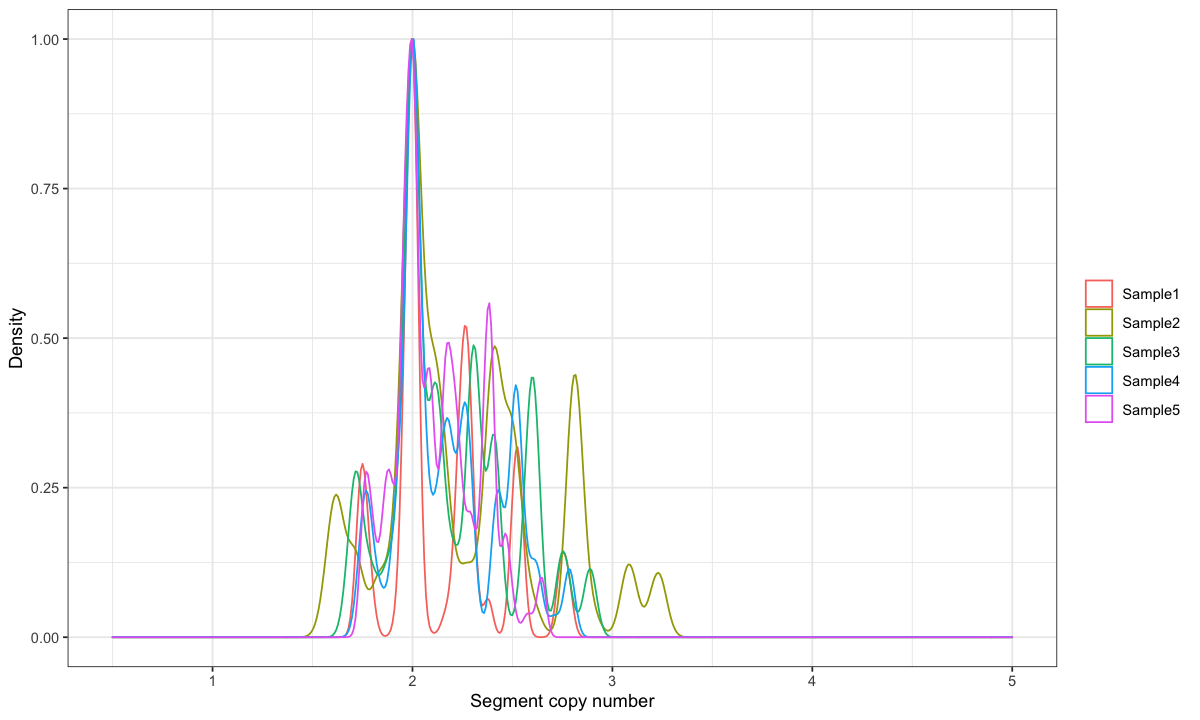

In [289]:
ggplot(reshape2::melt(seg.df), aes(x=value,y=..scaled.., colour=variable)) +
    geom_density(adjust=1) +
    theme_bw() + scale_x_continuous(limits=c(0.5, 5)) +
    labs(x='Segment copy number',y='Density',colour='')

## Pre-process sequencing information
### Filter out small segments and discard noisy bins

Create a vector that registers when any sample changes value - this way inconsistent break-points between samples are handled by creating new (small) ensemble segments around breakpoints

Based on this information, generate a dataframe of ensemble segments, contiguous sections of bins that are constant in all samples

In [164]:
segchange <- sapply(1:(nrow(seg.df)-1),function(i) sum(seg.df[i,]!=seg.df[(i+1),])>0)
                    
seg.data <- data.frame(start=c(1,which(segchange)+1),
                     end=c(which(segchange),length(segchange)+1))
seg.data$length <- seg.data$end - seg.data$start+1
                    

Retain only segments above a certain length, e.g. >120 (x50kB) bins

In [165]:
seg.sub <- subset(seg.data, length>120)
cat('Total number of segments retained: ',nrow(seg.sub))

Total number of segments retained:  84

Update segment values by fitting a normal distribution to bins in the segment

Store segment CN values (1 value per segment), the first variable returned by the fit

In [166]:
seg.fit <- getNormalFitSegments(seg.sub, cn.df)

seg.cns <- seg.fit[[1]]
names(seg.cns) <- names(seg.df)

Also generate an updated seg.df, in which segment CN values are repeated according to the number of bins they contain


In [167]:
seg.df.upd <- data.frame(matrix(NA, ncol=ncol(seg.df), nrow=nrow(seg.df)))
names(seg.df.upd) <- names(seg.df); row.names(seg.df.upd) <- row.names(seg.df)

for(i in 1:nrow(seg.sub)){
    seg.df.upd[seg.sub$start[i]:seg.sub$end[i],] <- seg.cns[i,]
}

## Purity estimation

Define estimation parameters:
- weights of different CN states (e.g. if we know that the genome is <CN=4, then states above 4 can get low or 0 weight)
- assumed maximum CN so that solutions with peaks matching higher values can be penalised (to avoid identifying half of the true purity value)
- adjustments/multiplier values for the smoothing kernel used in obtaining the CN distribution (a good default is including an array of multipliers below and above one)
- range of purity values to be evaluated

In [196]:
w = c(0.8,1,1,0.15,0.05)
maxCN=8
adjVec = c(0.5,0.6,0.8,0.9,1,1.2,1.3,1.5,1.8,2)
pVec = seq(0.05, 0.5, by=0.005)

Estimated optimal values (minimising the mean and the median over different kernels) are stored in pHat.df

The plots show the error of the fit over the range of purity values for all samples and can be used to manually adjust values afterwards

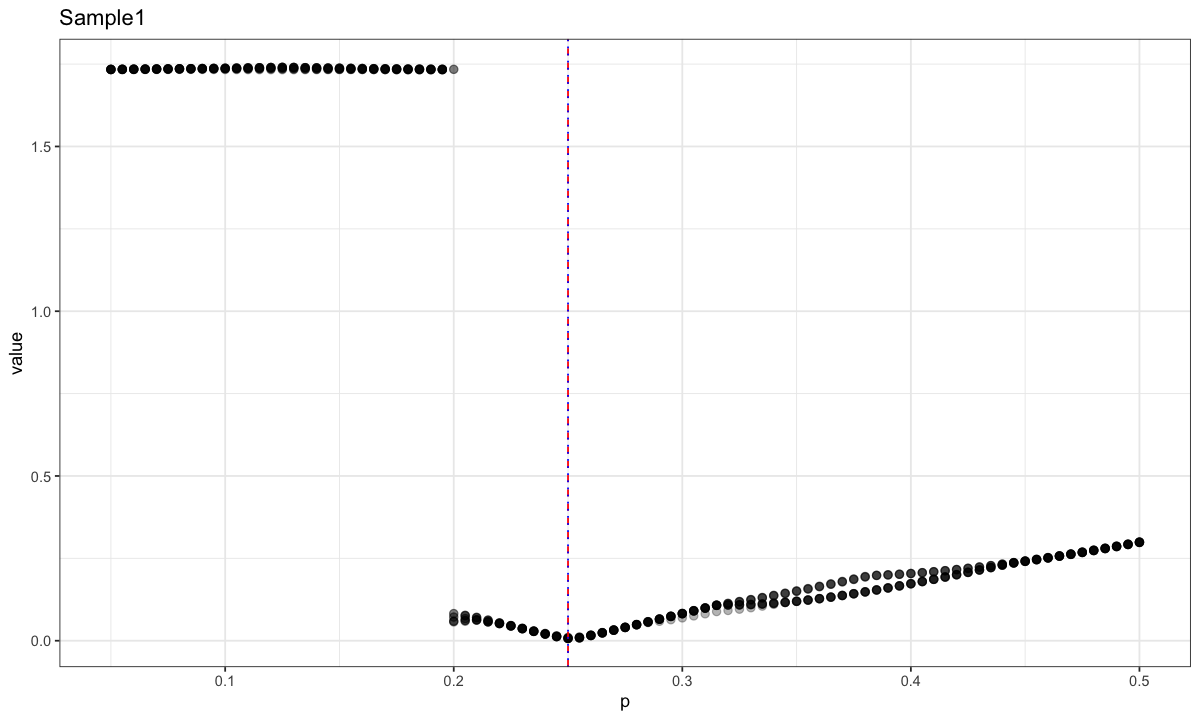

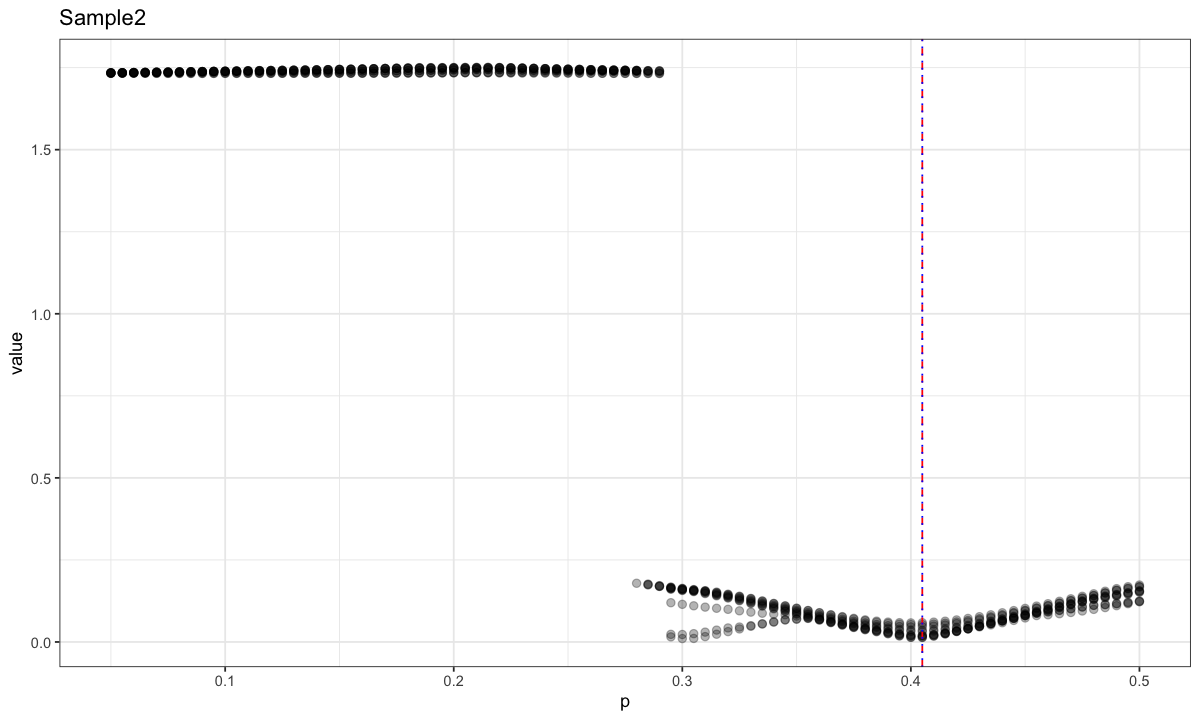

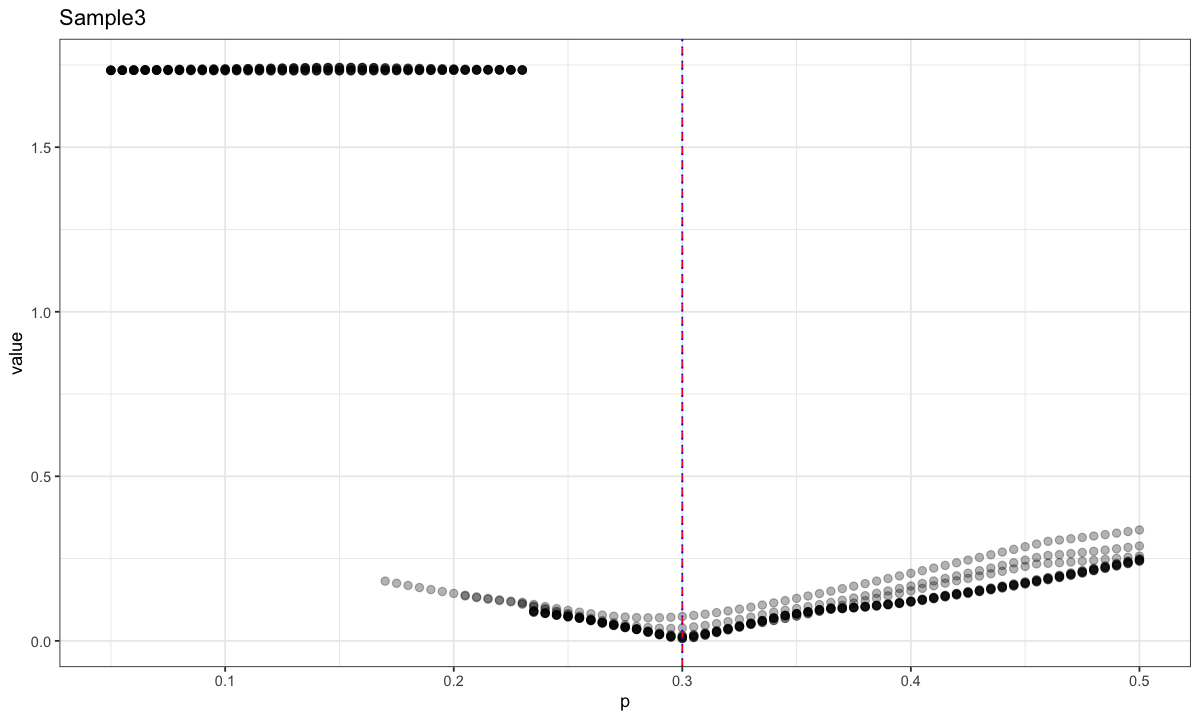

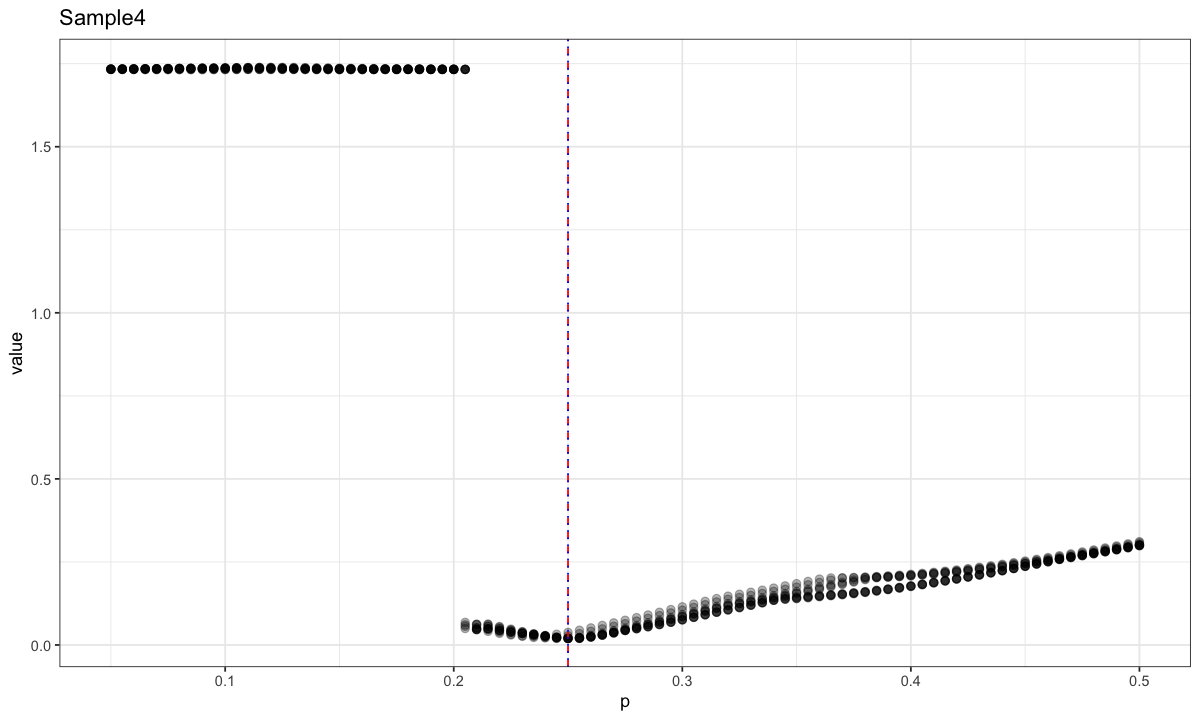

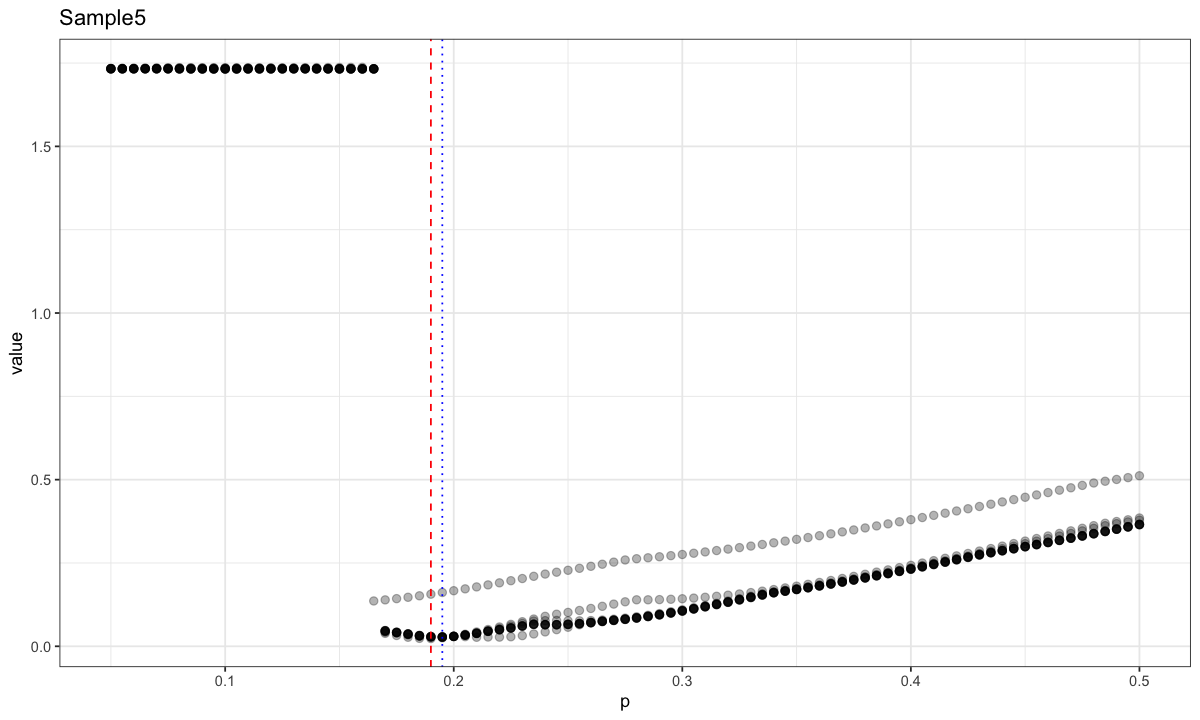

In [197]:
pHat.df <- data.frame(matrix(vector(),ncol=ncol(seg.df.upd), nrow=2))
names(pHat.df) <- names(seg.df.upd)
row.names(pHat.df) <- c('mean','median')

for(i in 1:ncol(seg.df.upd)){
    x <- na.omit(seg.df.upd[,i])
    pFits <- as.data.frame(sapply(adjVec,
                           function(a) sapply(pVec,
                                  function(p) evalPurityDensity(p,w,a,x,maxCN))))
    pFits$p <- pVec
    mins <- c(pVec[which.min(apply(pFits[,1:length(adjVec)],1,mean))],
          pVec[which.min(apply(pFits[,1:length(adjVec)],1,median))])
    plF <- ggplot(melt(pFits,id='p'), aes(x=p, y=value)) + geom_point(size=2, alpha=0.3)+
            theme_bw() +
            geom_vline(xintercept = mins, linetype=c('dashed','dotted'), colour=c('red','blue')) +
                          labs(title=names(seg.df.upd)[i])
    print(plF)
    pHat.df[,names(seg.df.upd)[i]] <- mins
}

In [199]:
cat('Estimated purity values:\n')
print(pHat.df)

Estimated purity values:
       Sample1 Sample2 Sample3 Sample4 Sample5
mean      0.25   0.405     0.3    0.25   0.190
median    0.25   0.405     0.3    0.25   0.195


Correct segment CN values (stored in seg.df.upd and seg.cns) with the computed purities using
- CN_corr = 1/p * (CN-2) + 2

In [200]:
pVec <- as.numeric(pHat.df[1,,drop=T])

seg.df.corr <- as.data.frame(t(t(seg.df.upd-2)*1/pVec)+2)
seg.cns.corr <- as.data.frame(t(t(seg.cns-2)*1/pVec)+2)

(Optional) Exlude samples from downstream analysis that are below a certain purity threshold (e.g. 0.1)

In [201]:
purity_threshold <- 0.1
abovePurTh <- pVec>= purity_threshold

seg.df.corr <- seg.df.corr[,abovePurTh]
seg.cns.corr <- seg.cns.corr[,abovePurTh]

Plot purity-corrected segment distribution, which then can be used for manually inspecting and correcting purity estimates

No id variables; using all as measure variables

Warning message:
“Removed 5650 rows containing non-finite values (stat_density).”


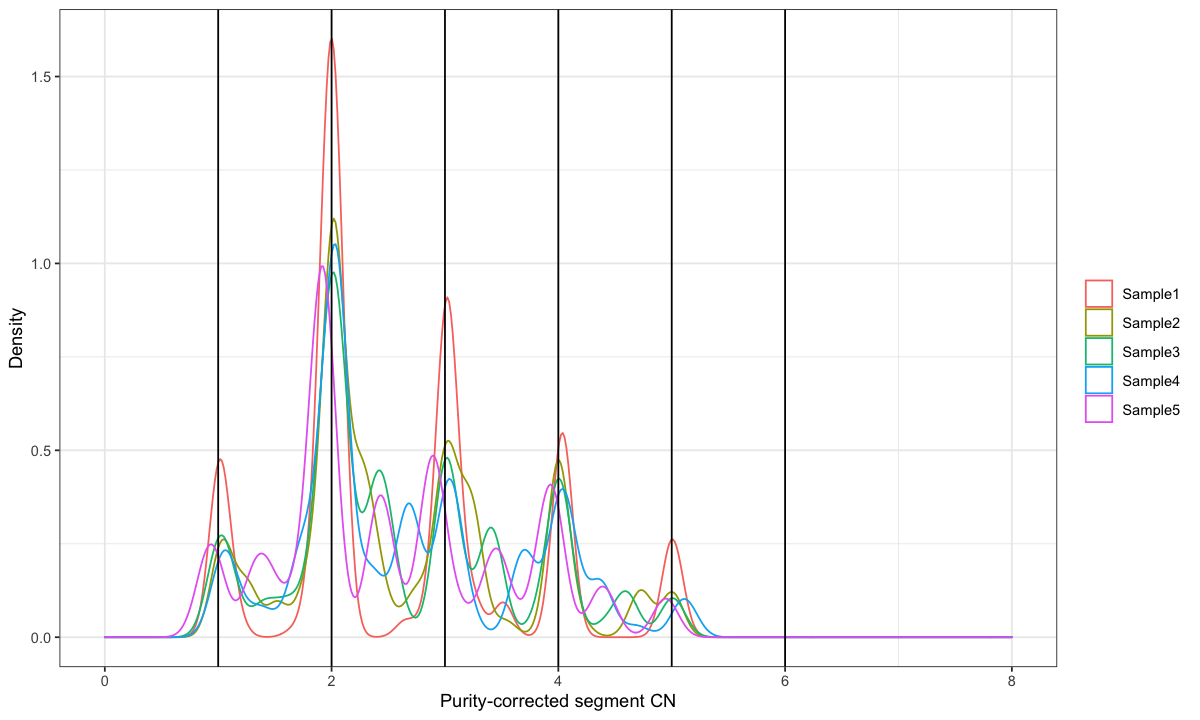

In [304]:
ggplot(melt(as.data.frame(seg.df.corr)), aes(x=value, colour=variable)) +
    geom_density(adjust=1) + theme_bw() +
    scale_x_continuous(limits=c(0,8)) + geom_vline(xintercept = 1:6) +
labs(x='Purity-corrected segment CN',y='Density',colour='')

(Optional) If the derived purity estimates seem erroneous, the estimation could be re-run with different parameter values. Alternatively, values could be manually inputted into pVec (based on the plot above or values derived from an alternative method) and the correction re-run. Small deviations (arising from an estimation error <0.01) can typically be ignored.

In [313]:
pVec[5] <- 0.19

seg.df.corr <- as.data.frame(t(t(seg.df.upd-2)*1/pVec)+2)
seg.cns.corr <- as.data.frame(t(t(seg.cns-2)*1/pVec)+2)

## Derive sample order and subclonal segments

Designate a baseline sample and compute DeltaCN values compared to this sample

In [314]:
baseSample <- 'Sample1'
seg.dcn <- seg.cns.corr - seg.cns.corr[,baseSample]
seg.dcn.nonBase <- seg.dcn %>% select(-one_of(baseSample))

Choose samples to investigate (all non-base samples by default) and generate all possible permutations

In [315]:
colToUse <- names(seg.dcn.nonBase)
nCol <- length(colToUse)
seg.dcn.toOrder <- seg.dcn.nonBase[,colToUse]
ordVec <- permutations(nCol,nCol,colToUse)

Set parameters to be used when evaluating sample order and segment monotony
- method for pre-filtering segments to exclude those that are clonal (dcn near-zero, e.g. by observing their standard deviation)
- cut-off values evaluated for pre-filtering
- epsilon error margin allowed in evaluating the monotony of orderings

In [316]:
filterMethod <- 'sd'
cutOffVec <- seq(0.025,0.3,by=0.005)
epsilon <- 0.05

Find optimal ordering of samples according to pre-filtered samples at varying cut-off values

Diagnostic plots show - at different pre-filtering clonal cut-off values - the proportion of subclonal segments (of non-clonal segments) and the total number of non-clonal (light blue) and subclonal (dark blue) segments

Typically, too low cut-offs will lead to a low subclonal segment proportion, as they over-emphasise noisy clonal segments do not follow the pattern of an emerging subclone. On the other hand, too high cut-offs will emphasise a few segment with high variability that might also arise from noise rather than the emerging subclone. A typical cut-off ~0.1 is adequate for most datasets, but might depend on the data generation method.

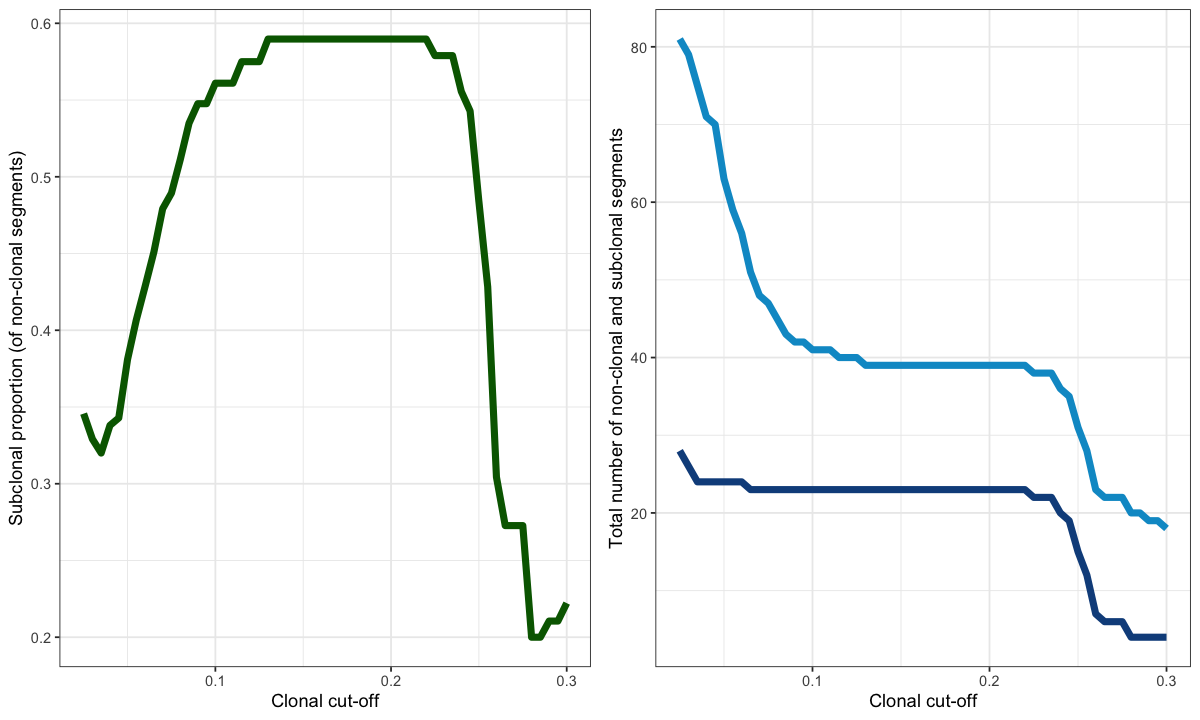

In [317]:
fitInfo <- list()
for (cutOff in cutOffVec){
    seg.dcn.Eval <- filterSegmentRatios(seg.dcn.toOrder, cutOff, filterMethod, 0)
    best <- findBestOrder(seg.dcn.Eval, ordVec, epsilon, nCol, 0)
    fitInfo[[as.character(cutOff)]] <- best
    }

fitInfo.df <- data.frame(cutOff = cutOffVec,
                         maxFit = sapply(fitInfo, function(x) x$max),
                         segsAboveCut = sapply(fitInfo, function(x) length(x$cons)),
                         segsInOrder = sapply(fitInfo, function(x) max(sapply(x$segs, length))))
p1 <- ggplot(fitInfo.df, aes(x=cutOff, y=maxFit)) + geom_line(size=2,colour='darkgreen') + theme_bw() +
            labs(x='Clonal cut-off',y='Subclonal proportion (of non-clonal segments)')
p2 <- ggplot(fitInfo.df, aes(x=cutOff, y=segsAboveCut)) + geom_line(size=2,colour='deepskyblue3') +
            geom_line(aes(y=segsInOrder), size=2,colour='dodgerblue4') + theme_bw() +
            labs(x='Clonal cut-off',y='Total number of non-clonal and subclonal segments')
grid.arrange(p1,p2,nrow=1)

If choosing manually, the recommended value should associate with a reasonable number of subclonal segments (5-20) while maximises the subclonal proportion. Alternatively, the optimal cut-off can be derived automatically to contain a certain numbero f subclonal segments (e.g. 12) and provide the maximal subclonal proportion. If we have no estimate of how many subclonal segments should be present, this call can be repeated with a range of numbers.

In [318]:
minSegmentNumber <- 12
cat('Recommended cut-off is: ',getCutOffAuto(fitInfo.df, minSegmentNumber))

Recommended cut-off is:  0.13

Choose a particular cut-off to use and find the best sample ordering and segments classification (evaluated above) 

Then plot DeltaCN values according to this ordering for inspection. If more than one optimal sample orders exists (e.g. if two samples have equal subclonal proportion), all orders are plotted.

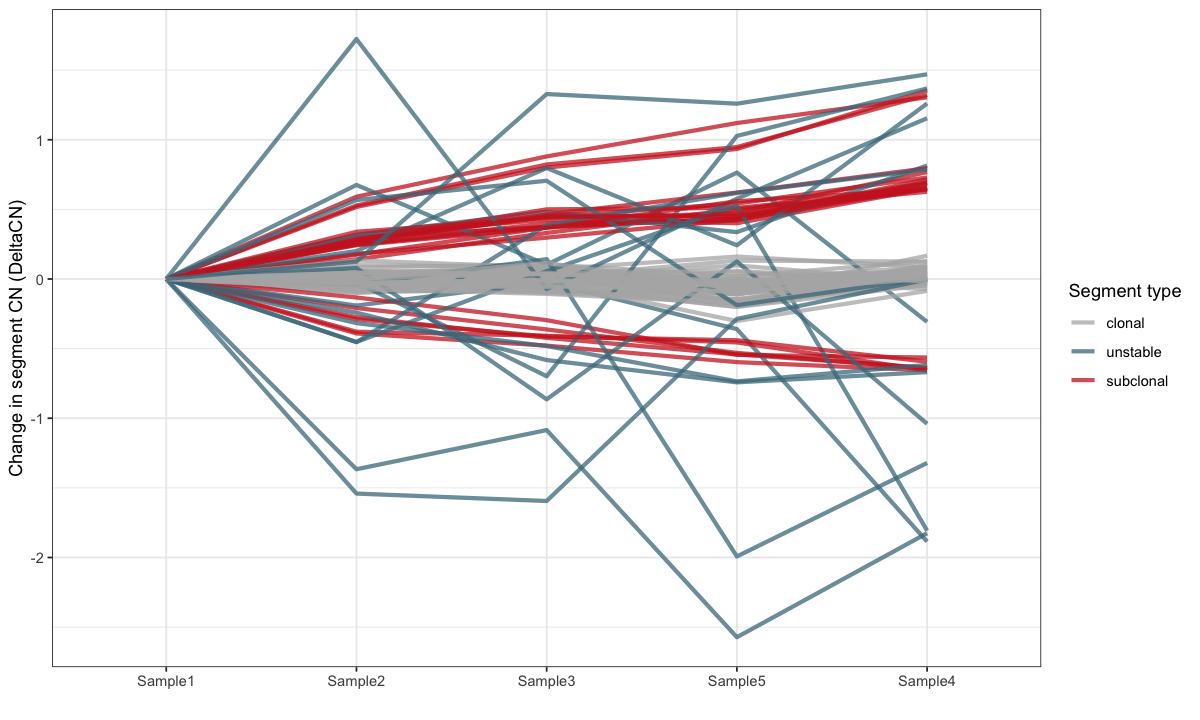

In [319]:
cutOff <- 0.13
fit <- fitInfo[[as.character(cutOff)]]

for (ind in 1:nrow(fit$ord)){
    seg.plot <- seg.dcn[,rev(c(fit$ord[ind,],baseSample))]
    seg.plot$id <- row.names(seg.plot)
    seg.plot$filtered <- seg.plot$id %in% fit$cons
    seg.plot$order <- seg.plot$id %in% fit$segs[[ind]]
    
    p <- ggplot(melt(seg.plot, id=c('id','filtered','order')), aes(x=variable, y=value, group=id, colour=paste0(filtered,' | ',order))) +
    geom_line(size=1.2, alpha=0.75) + theme_bw() +
    scale_colour_manual(values=c('grey70','#487a8b','firebrick3'), labels=c('clonal','unstable','subclonal')) +
    labs(x='',y='Change in segment CN (DeltaCN)',colour='Segment type')
    print(p)
}

Choose manually which sample ordering to use if multiple ones are available (otherwise default is the first one), and generate re-ordered and filtered segment DeltaCN matrix that only contains subclonal segments and in the correct order

In [320]:
ordInd <- 1
seg.dcn.toUse <- seg.dcn[fit$segs[[ordInd]],rev(fit$ord[ordInd,])]

## Derive relative and absolute subclonal-ratio

### Relative subclonal-ratio estimates
Generate relative ratio estimates by segment-by-segment comparison to the highest subclonal-ratio sample (located in the last column)

Derive point estimates as the median of all estimates per sample

In [321]:
topSample <- names(seg.dcn.toUse)[ncol(seg.dcn.toUse)]
toEstimate <- setdiff(names(seg.dcn.toUse), c(topSample,baseSample))

final.ratios <- estimateRSegmentRatio(seg.dcn.toUse, toEstimate, topSample, 1)

final.medians <- aggregate(final.ratios$value, by=list(final.ratios$variable), median)

Plot estimated relative ratios (with medians indicated)

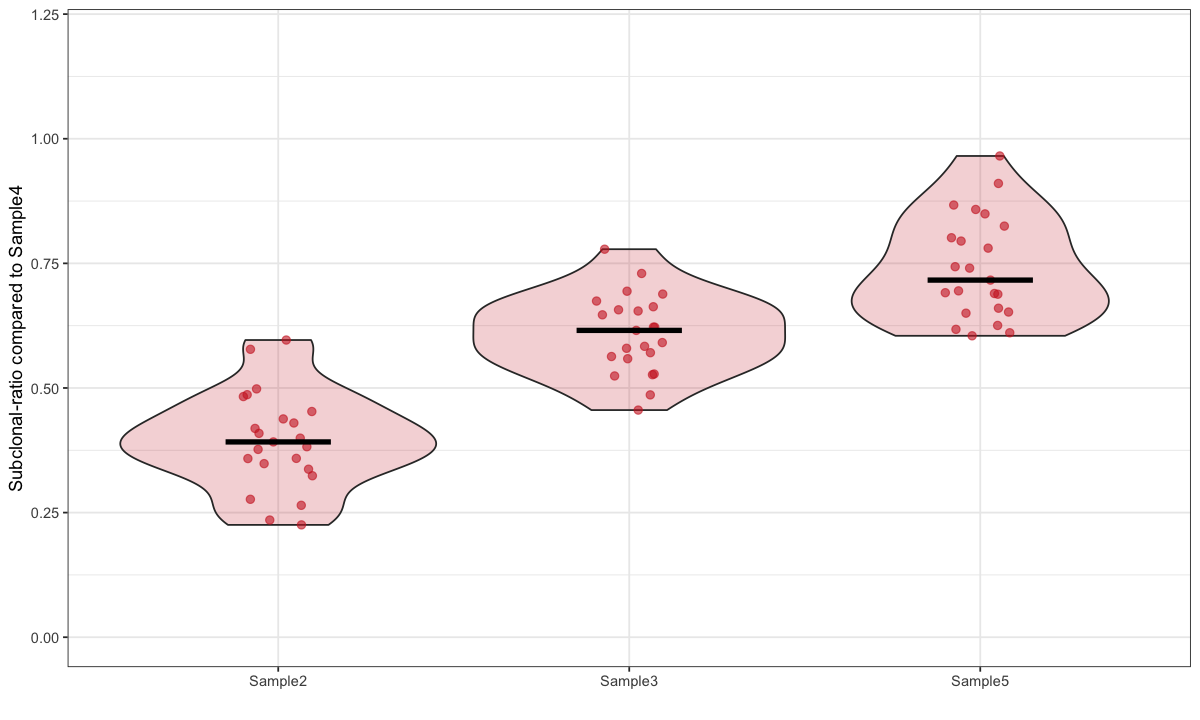

In [322]:
final.medians$xpos <- 1:nrow(final.medians)

ggplot(final.ratios, aes(y=value, x=variable, weight=1)) + geom_violin(fill='firebrick3',alpha=0.2) +
    theme_bw() + scale_y_continuous(limits=c(0,1.2)) +
    geom_jitter(width=0.1, height=0, colour='firebrick3', size=2, alpha=0.6) +
    #geom_point(data=true.df, aes(x=V3, y=V2), colour='firebrick3', size=3) +
    geom_segment(data=final.medians,aes(x=xpos-0.15,xend=xpos+0.15,y=x,yend=x), size=1.5) +
    labs(x='',y=paste0('Subclonal-ratio compared to ',topSample))

If true underlying values are known (e.g. for synthetic example data), generate an additional plot including that information

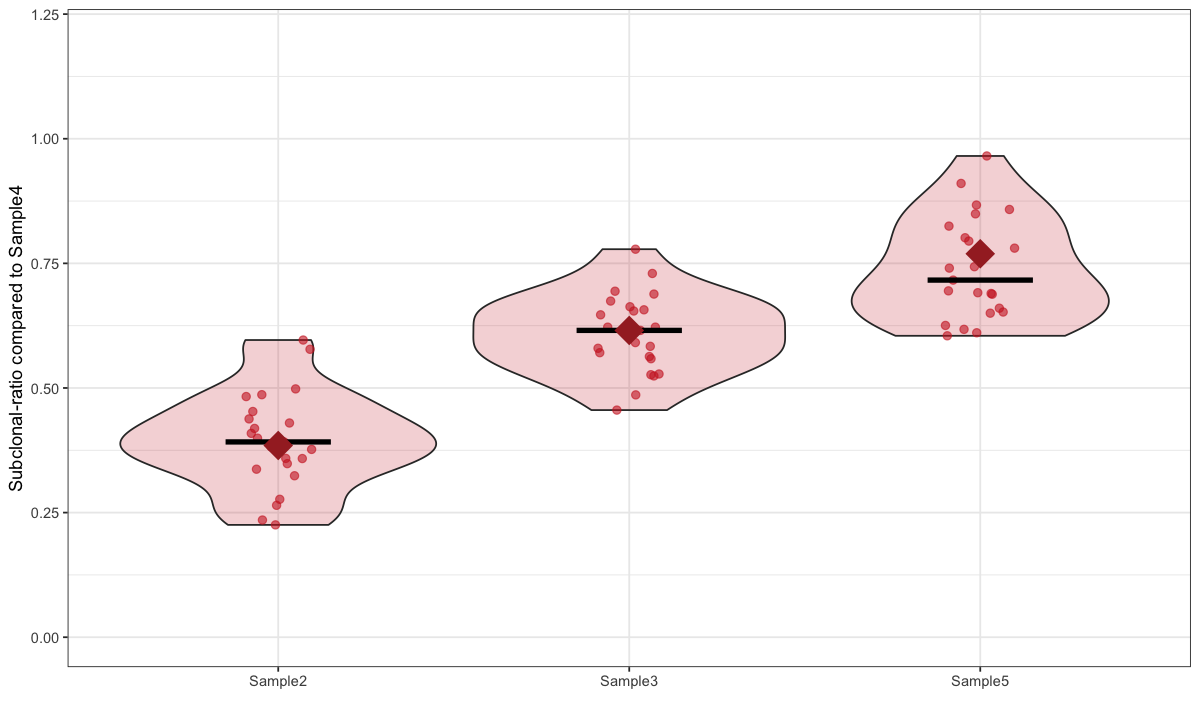

In [323]:
true.df <- params.df[params.df$time %in% final.ratios$variable,]
true.df$ratio <- true.df$ratio / params.df[params.df$time==topSample, 'ratio']
ggplot(final.ratios, aes(y=value, x=variable, weight=1)) + geom_violin(fill='firebrick3',alpha=0.2) +
    theme_bw() + scale_y_continuous(limits=c(0,1.2)) +
    geom_jitter(width=0.1, height=0, colour='firebrick3', size=2, alpha=0.6) +
    geom_segment(data=final.medians,aes(x=xpos-0.15,xend=xpos+0.15,y=x,yend=x), size=1.5) +
    geom_point(data=true.df, aes(x=time, y=ratio), colour='brown', size=8, shape=18) +
    labs(x='',y=paste0('Subclonal-ratio compared to ',topSample))

Create a final results table to store median relative ratio values, and add a row to represent the highest subclonal-ratio sample (relative ratio of 1)

In [324]:
final.results <- aggregate(final.ratios$value, by=list(final.ratios$variable), median)
names(final.results) <- c('time','relratio')
final.results$time <- as.character(final.results$time)
final.results[nrow(final.results)+1,] <- c(topSample, 1)

### Absolute subclonal-ratio estimates
Generate absolute ratio estimates by fitting a Gaussian mixture model of constrained means to each sample, where the shared mean parameter defines the absolute ratio

To also derive the variance of the estimate, we can provide the number of distinct DeltaCN states the segment values are distributed over, e.g. 3 (-1, 1, 2) - the default is 2.

In [325]:
final.results$rat <- NA
final.results$rat_sd <- NA
for (samp in final.results$time){
    final.results <- estimateRGaussianFit(seg.dcn.toUse, samp, final.results, 3)
}
final.results$rat_sd <- as.numeric(final.results$rat_sd)

number of iterations= 6 
number of iterations= 3 
number of iterations= 3 
number of iterations= 3 


Plot estimated absolute ratios with 95% confidence intervals computed from the variance of each estimate

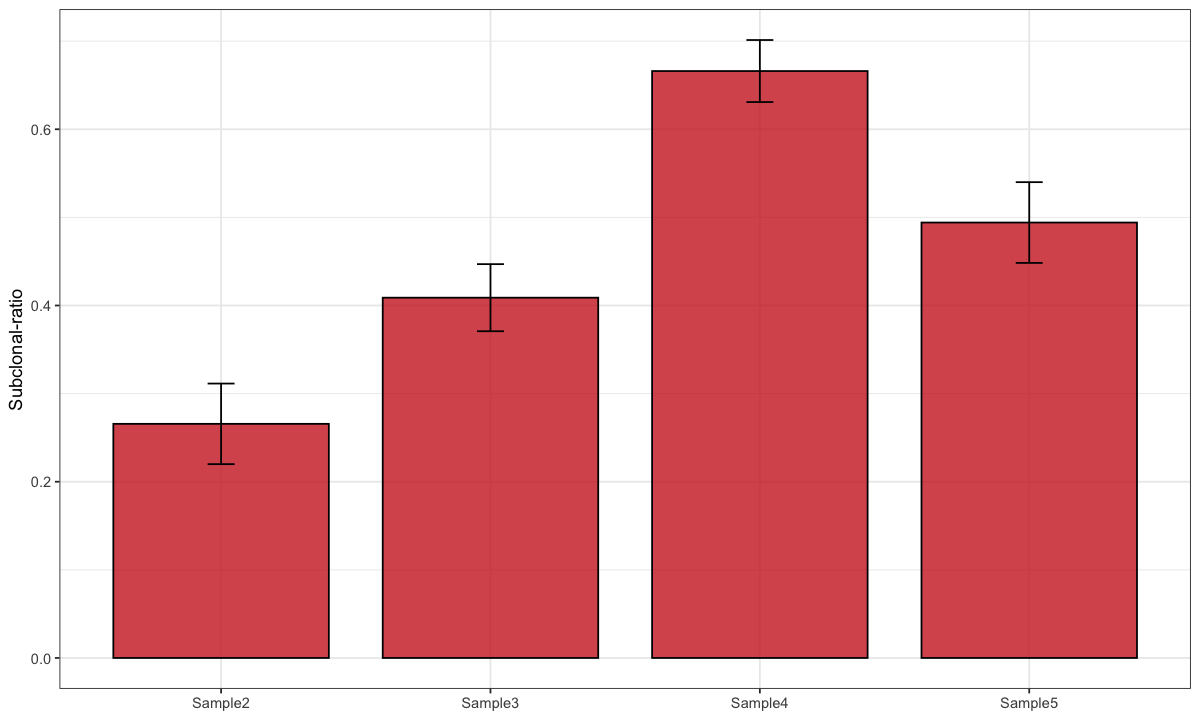

In [326]:
ggplot(final.results, aes(x=as.factor(time), y=rat)) +
    geom_bar(stat='identity',colour='black',fill='firebrick3',alpha=0.8, width=0.8) +
    geom_errorbar(aes(ymin=(rat-(1.96*rat_sd))*((rat-(1.96*rat_sd))>0), ymax=rat+(1.96*rat_sd)),
                  width=.1) +
    theme_bw() + theme(axis.title.x=element_blank()) +
    labs(x='Sample', y='Subclonal-ratio')

If the true underlying values are known, generate an additional plot including this information

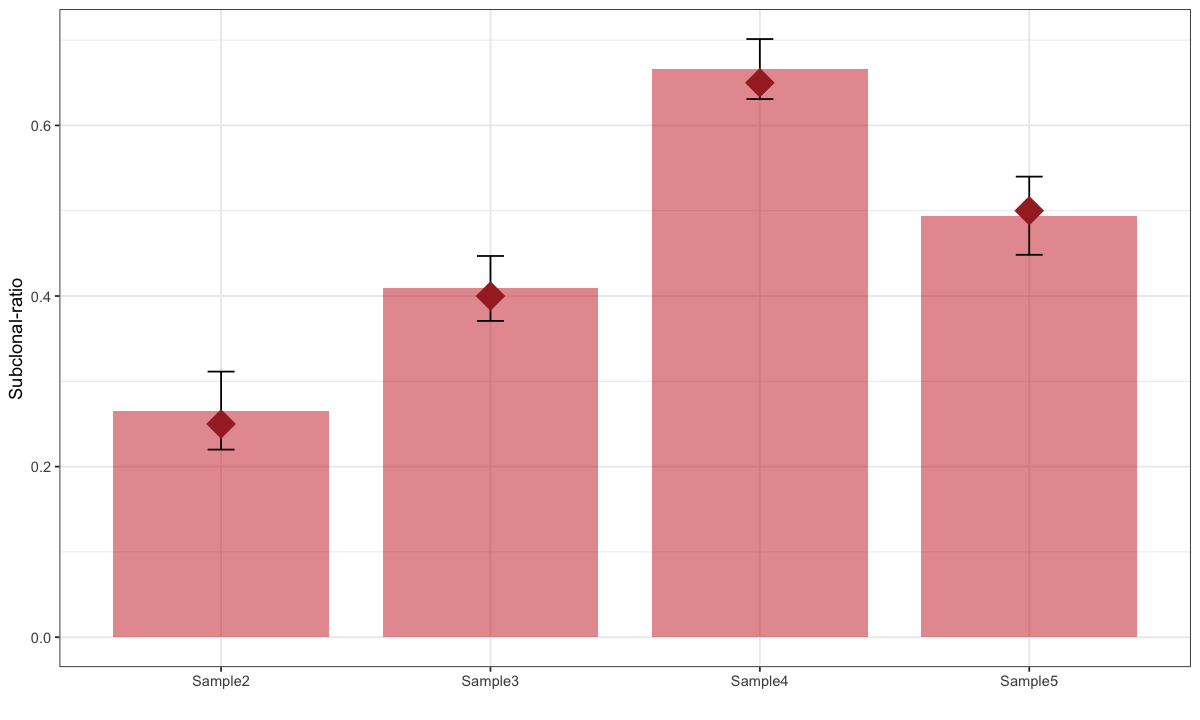

In [327]:
true.df <- params.df[params.df$time %in% final.results$time,]
true.df$ratio <- true.df$ratio / 100
ggplot(final.results, aes(x=time, y=rat)) +
    geom_bar(stat='identity',width=0.8,alpha=0.5, fill='firebrick3',colour=NA) +
    geom_errorbar(aes(ymin=(rat-(1.96*rat_sd))*((rat-(1.96*rat_sd))>0), ymax=rat+(1.96*rat_sd)),
                  width=.1) +
    theme_bw() +
    geom_point(data=true.df, aes(x=as.factor(time), y=ratio), colour='brown', size=8, shape=18) +
    labs(x='', y='Subclonal-ratio')

## Final results
Compile a table with all samples (including baseline sample) and estimates derived for them

In [328]:
final.results[nrow(final.results)+1,] <- c(baseSample, 0,0,0)
final.results$purity_mean <- as.numeric(pHat.df[1,match(final.results$time, names(pHat.df))])
final.results$purity_median <- as.numeric(pHat.df[2,match(final.results$time, names(pHat.df))])


cat('Final result table:\n')
print(final.results)

Final result table:
     time          relratio               rat             rat_sd purity_mean
1 Sample2 0.391779442936719 0.265686845062644 0.0233269099310827       0.405
2 Sample3 0.615512322044032 0.408865996157688 0.0194220242607597       0.300
3 Sample5 0.716417859611923 0.494142601618757 0.0233806394380352       0.190
4 Sample4                 1 0.666064895270877 0.0179595072034013       0.250
5 Sample1                 0                 0                  0       0.250
  purity_median
1         0.405
2         0.300
3         0.195
4         0.250
5         0.250


In [330]:
R.Version()

$platform
[1] "x86_64-apple-darwin17.0"

$arch
[1] "x86_64"

$os
[1] "darwin17.0"

$system
[1] "x86_64, darwin17.0"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.3"

$year
[1] "2020"

$month
[1] "10"

$day
[1] "10"

$`svn rev`
[1] "79318"

$language
[1] "R"

$version.string
[1] "R version 4.0.3 (2020-10-10)"

$nickname
[1] "Bunny-Wunnies Freak Out"